In [1]:
import gudhi
import itertools
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from random import randint
import time

In [2]:
#Build a simplex tree with edge collapsing
def build_st(P):
    """
    Input: P is a nxd data set
    Output:return a simplex tree
    """
    rips_complex = gudhi.RipsComplex(points=[P[i] for i in range(P.shape[0])])
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
    #simplex_tree.collapse_edges()
    #simplex_tree.expansion(2)
    
    return simplex_tree


#Computing the persistence interval set D
def get_interval(K):
    """
    Input: a simplicial complex K
    Output:a dictionary in the form of {(<persistence interval>): <simplicial complex>}
    """
    simplex_tree = K
    int_info = {}
    filt = []
    for i in simplex_tree.get_filtration(): # a list: [((simplex), <filtration value>)]
        filt.append(i)
    pers = []
    max_dt = 0
    for i in simplex_tree.persistence():
        if i[1][1] >= max_dt and i[1][1] != np.inf:
            max_dt = i[1][1]
    for i in simplex_tree.persistence(): # a list: [([dimension], (<persistence interval>))]
        if i[1][1] == np.inf:
            pers.append((i[0], (i[1][0], max_dt)))
        else:
            pers.append(i)
    for i in pers:
        if i[0] == 1:
            l, u = i[1]
            st = gudhi.SimplexTree()
            for j in filt:
                if j[1] <= l:
                    st.insert(j[0], j[1])
            int_info[(l, u)] = st
        
    return int_info

In [3]:
def choose_int(int_info, method):
    """
    arg: method can be "max"|"rand"|"avg"
    Output: a filtration chosen from max persistence interval
    """
    f = None
    intervals = list(int_info.keys())
    avg_d = np.mean([abs(i[0]-i[1]) for i in intervals])
    max_d = np.max([abs(i[0]-i[1]) for i in intervals])
    rand  = randint(0,len(intervals)-1)
    if method == 'max':
        for i in intervals:
            if abs(i[0]-i[1]) == max_d:
                inte = i
                f = int_info[inte]
    elif method == 'rand':
        inte = intervals[rand]
        f = int_info[inte]
    elif method == 'avg':
        d = np.inf
        for i in intervals:
            if abs(avg_d - abs(i[0]-i[1])) <= d:
                inte = i
                f = int_info[inte]
                d = abs(avg_d - abs(i[0]-i[1]))

    return f, inte

([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([1, 2], 0.22360679774997894)
([0, 2], 0.806225774829855)
([2, 3], 0.9219544457292888)
([0, 1], 1.0)
([0, 1, 2], 1.0)
([1, 3], 1.0)
([1, 2, 3], 1.0)
([0, 4], 1.0)
([3, 4], 1.0)
([2, 4], 1.2041594578792296)
([0, 2, 4], 1.2041594578792296)
([2, 3, 4], 1.2041594578792296)
([0, 3], 1.4142135623730951)
([0, 1, 3], 1.4142135623730951)
([0, 2, 3], 1.4142135623730951)
([0, 1, 2, 3], 1.4142135623730951)
([1, 4], 1.4142135623730951)
([0, 1, 4], 1.4142135623730951)
([1, 2, 4], 1.4142135623730951)
([0, 1, 2, 4], 1.4142135623730951)
([0, 3, 4], 1.4142135623730951)
([1, 3, 4], 1.4142135623730951)
([0, 1, 3, 4], 1.4142135623730951)
([0, 2, 3, 4], 1.4142135623730951)
([1, 2, 3, 4], 1.4142135623730951)
(1, (1.0, 1.2041594578792296))
(0, (0.0, inf))
(0, (0.0, 1.0))
(0, (0.0, 0.9219544457292888))
(0, (0.0, 0.806225774829855))
(0, (0.0, 0.22360679774997894))
([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([1, 2], 0.22360679774997894)
([0, 2], 

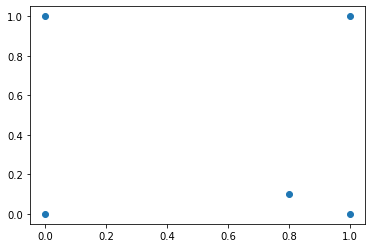

In [4]:
P = np.array([[0, 0], [1, 0], [0.8, 0.1], [1, 1], [0, 1]])
plt.plot([0,1,0.8,1,0],[0,0,0.1,1,1],'o')
rips_complex = gudhi.RipsComplex(points=P,max_edge_length=1.5)
st = rips_complex.create_simplex_tree(max_dimension=3  )
for i in st.get_filtration():
    print(i)
print("===================")
for i in st.persistence():
    print(i)
print("===================")
K = choose_int(get_interval(st), 'max')[0]
for i in K.get_filtration():
    print(i)
print("===================")
print(choose_int(get_interval(st), 'max')[1])

In [5]:
def get_faces(simplex_list):
    faces = []
    dimension = len(simplex_list) - 1
    for i in range(1, dimension+2):
        simplex_dim_i = list(itertools.combinations(simplex_list,i))
        for k in simplex_dim_i:
            faces.append(list(k))
    return faces


def get_link(v, simplex_tree):
    # Find the link of a vertex v in the form of list []
    link = []
    star = simplex_tree.get_star(v)
    for simplex in star:
        faces = get_faces(simplex[0])
        for face in faces:
            if v[0] not in face:
                candidate = (face, simplex_tree.filtration(face))
                if candidate not in link:
                    link.append(candidate)
    return link

In [6]:
# Associate function
# Map each simplex to a list with each component represents the number of a label 
def Assocaition_function(N, label_list, simplex):
    assocation_value = [0 for i in range(N)]
    for vertex in simplex:
        label_of_vertex = label_list[vertex]
        #print("vertex is", vertex, "with label", label_of_vertex)
        assocation_value[label_of_vertex] += 1
    return assocation_value


# Extension function
# Map each vertex to a list with each component represents a_i
def Extension_function(simplex_tree, N, label_list, vertex):
    Extension_value = np.zeros((N))
    link = get_link(vertex, simplex_tree)
    #print(link)
    for simplex in link:
        if simplex[1] != 0:
            Extension_value += (1/simplex[1]) * np.array(Assocaition_function(N, label_list, simplex[0]))
        else:
            # filtration 为0的simplex 设置为 0.1
            Extension_value += 10 * np.array(Assocaition_function(N, label_list, simplex[0]))
    return list(Extension_value)


def predict_label(extension_value):
    return extension_value.index(max(extension_value))

In [7]:
# Store the label of each vertex in a list
# Label represented by natural number
label_value_list = [0,0,0,1,1]
# N is the number of labels 
N = len(set(label_value_list))
N

2

In [8]:
Dataset = np.c_[P,np.array(label_value_list)]
Dataset

array([[0. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0.8, 0.1, 0. ],
       [1. , 1. , 1. ],
       [0. , 1. , 1. ]])

In [9]:
# 无问题
Assocaition_function(N, label_value_list, [4])

[0, 1]

In [13]:
choosen_simplex_tree = K
Extension_function(choosen_simplex_tree, N, label_value_list, [2]) # 预测正确

[23.0, 11.0]

([], [])

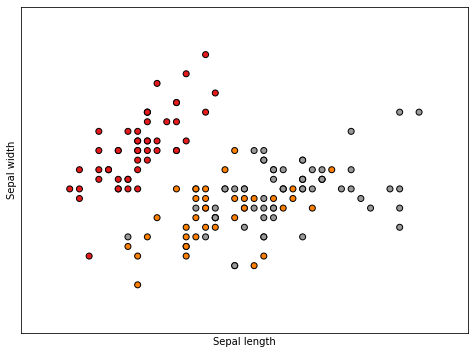

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data  
y = iris.target
pca = PCA(2)# we only take the first two features.
z = pca.fit_transform(X)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

In [15]:
rips_complex = gudhi.RipsComplex(points=z)
st = rips_complex.create_simplex_tree(max_dimension=3)
K = choose_int(get_interval(st), 'max')[0]

# Store the label of each vertex in a list
# Label represented by natural number
label_value_list = list(y)
# N is the number of labels 
N = len(set(label_value_list))

choosen_simplex_tree = K

In [20]:
pred_y = []
for i in range(len(X)):
    extension_value = Extension_function(choosen_simplex_tree, N, label_value_list, [i])
    pred_y.append(predict_label(extension_value))
pred_y = np.array(pred_y)

In [17]:
for m in ['max', 'avg', 'rand']:
    start_time = time.time()
    K = choose_int(get_interval(st), m)[0]
    pred_y = []
    for i in range(len(z)):
        extension_value = Extension_function(choosen_simplex_tree, N, label_value_list, [i])
        pred_y.append(predict_label(extension_value))
    pred_y = np.array(pred_y)
    print("Using TDABC",m,'has accuracy', np.sum(pred_y == y)/len(z))
    print("--- %s seconds ---" % (time.time() - start_time))

Using TDABC max has accuracy 0.94
--- 105.9410650730133 seconds ---
Using TDABC avg has accuracy 0.94
--- 117.15555882453918 seconds ---
Using TDABC rand has accuracy 0.94
--- 151.39035081863403 seconds ---


In [21]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(z, y)

print(np.sum(neigh.predict(z) == y)/len(z))
print("--- %s seconds ---" % (time.time() - start_time))

0.9933333333333333
--- 0.013247966766357422 seconds ---


In [25]:
#experiment on 
data = []
with open('mfeat.txt', 'r') as file:
    for row in file: 
        sp  = []
        lst = row.strip().split(' ') 
        for ele in lst:
            if ele != '':
                sp.append(float(ele))
        data.append(sp)
n = len(data)
p = len(data[0])
X = np.zeros((n,p))
for i in range(n):
    X[i] = data[i]

pca = PCA(2)
Y = pca.fit_transform(X)
z = np.zeros((150,2))   
z[:50] = Y[:50]
z[50:100] = Y[200:250]
z[100:150] = Y[400:450]
true_label = [0]*50+[1]*50+[2]*50

N = 3                           
rips_complex = gudhi.RipsComplex(points=z)
st = rips_complex.create_simplex_tree(max_dimension=3)
for m in ['max', 'avg', 'rand']:
    start_time = time.time()
    K = choose_int(get_interval(st), m)[0]
    pred_y = []
    for i in range(len(z)):
        extension_value = Extension_function(K, N, true_label, [i])
        pred_y.append(predict_label(extension_value))
    pred_y = np.array(pred_y)
    print("Using TDABC",m,'has accuracy', np.sum(pred_y == true_label)/len(z))
    print("--- %s seconds ---" % (time.time() - start_time))

Using TDABC max has accuracy 0.8466666666666667
--- 271.8079698085785 seconds ---
Using TDABC avg has accuracy 0.76
--- 141.19700622558594 seconds ---
Using TDABC rand has accuracy 0.7866666666666666
--- 116.37641716003418 seconds ---


In [26]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(z, true_label)

print(np.sum(neigh.predict(z) == true_label)/len(z))
print("--- %s seconds ---" % (time.time() - start_time))

0.8933333333333333
--- 0.030861854553222656 seconds ---


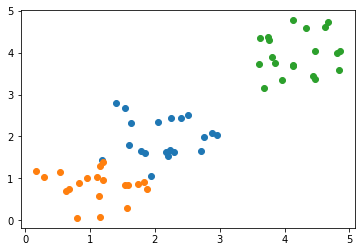

In [22]:
us1_x = []
us1_y = []
us2_x = []
us2_y = []
us3_x = []
us3_y = []
for i in range(20):
    # random angle
    alpha1 = 2 * math.pi * random.random()
    alpha2 = 2 * math.pi * random.random()
    alpha3 = 2 * math.pi * random.random()
    #random radius
    r1 = math.sqrt(random.random())
    r2 = math.sqrt(random.random())
    r3 = math.sqrt(random.random())
    #generate samples
    x1 = 2+math.cos(alpha1) * r1
    y1 = 2+math.sin(alpha1) * r1
    us1_x.append(x1)
    us1_y.append(y1)
    x2 = 1+math.cos(alpha2) * r2
    y2 = 1+math.sin(alpha2) * r2
    us2_x.append(x2)
    us2_y.append(y2)
    x3 = 4+math.cos(alpha1) * r3
    y3 = 4+math.sin(alpha1) * r3
    us3_x.append(x3)
    us3_y.append(y3)

plt.plot(us1_x, us1_y, 'o')
plt.plot(us2_x, us2_y, 'o')
plt.plot(us3_x, us3_y, 'o')

X = np.zeros((60,2))
X[:,0] = np.concatenate((us1_x, us2_x, us3_x))
X[:,1] = np.concatenate((us1_y, us2_y, us3_y))

In [23]:
true_label = [0]*20+[1]*20+[2]*20

rips_complex = gudhi.RipsComplex(points=X)
st = rips_complex.create_simplex_tree(max_dimension=3)
N = 3
for m in ['max', 'avg', 'rand']:
    start_time = time.time()
    K = choose_int(get_interval(st), m)[0]
    pred_y = []
    for i in range(len(X)):
        extension_value = Extension_function(K, N, true_label, [i])
        pred_y.append(predict_label(extension_value))
    pred_y = np.array(pred_y)
    print("Using TDABC",m,'has accuracy', np.sum(pred_y == true_label)/len(X))
    print("--- %s seconds ---" % (time.time() - start_time))

Using TDABC max has accuracy 0.9666666666666667
--- 1.1456270217895508 seconds ---
Using TDABC avg has accuracy 0.9666666666666667
--- 1.0527539253234863 seconds ---
Using TDABC rand has accuracy 0.9666666666666667
--- 1.0421149730682373 seconds ---


In [24]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
neigh = KNeighborsClassifier(n_neighbors=3)
true_label = [0]*20+[1]*20+[2]*20
neigh.fit(X, true_label)
print(np.sum(neigh.predict(X) == true_label)/len(X))
print("--- %s seconds ---" % (time.time() - start_time))

0.9666666666666667
--- 0.01034402847290039 seconds ---
